# Coupled Quantum Wells (Solid State Physics PHY60003)

#### Written by Rupert Oulton September 2021

Last update: 1st October 2021

For more info: r.oulton@imperial.ac.uk

Imperial College London

## Contents
[Summary](#summary)

[What this code calculates](#calculates)

[Interpretation of electron transport](#interpretations)

[Import Modules](#importModules)

[Define Parameters and Structure](#define)

[Transfer Matrix Functions](#transferMatrix)

[Displaying Results](#displayFunctions)

[Making your own calculations](#makeCalculations)

<a id='summary'></a>

## Summary
This code solves the 1D Schrodinger equation for electron propagation through for any series of potenital steps. In this particular case, the code is used to describe the transport of an electron through a series of quantum wells. Since each quantum well mimics an atom, large arrays of quanutm wells describe the transport of electrons through a 1D crystal. This resembles the Kronig Penny analytical model of a crystal's electronic states. 

Please start by running all cells in sequence without modifying the code. The [Results Section](#displayFunctions)  allows you to explore the physics of coupled quantum wells with a simple graphical interface. Once you are familiar with the physics, you can then use the code to make your own calculations in the ["Make Your Own Calculations" Section](#makeCalculations).

<a id='calculates'></a>

## What this code calculates
This code computes solutions to the Schrodinger equation:<br>
<br>
<center>$ \left( \frac{\hbar^2}{2m}\frac{d^2}{dx^2} + V_n\right)\psi(x) = E\psi(x)$

where $m$ is the electron mass, $E$ is the electron energy and $\psi(x)=e^{ik_nx}$ is the wave solution with<br>
<br>
<center>$ k_n = \sqrt{\frac{2m}{\hbar^2}(E-V_n)}$
    
being the electron wavenumber in region $n$ with potential energy $V_n$.
    
At an interface between regions of different potential, electrons may be scattered into forward waves, $a(x)e^{ik_nx}$, and backward waves, $\bar{a}(x)e^{-ik_nx}$. The propagation of these waves through a series of layers of varying potenital is then described by a transfer matrix. <br>
<br>
    
<center>$ \left(\begin{array}{c}  a(x) \\ \bar{a}(x) \end{array} \right) = T \left(\begin{array}{c}  a(0) \\  \bar{a}(0)  \end{array} \right)$
    
The transfer matrix is constructed from interfacial transfer matrices describing the scattering of electrons at an interface betwen regions of different potential,<br>
<br>
    
<center>$ T^{(I)}_{mn}=\frac{1}{2}\left(\begin{array}{cc} 1+\frac{k_n}{k_m} & 1-\frac{k_n}{k_m} \\ 1-\frac{k_n}{k_m} & 1+\frac{k_n}{k_m}  \end{array} \right)$

and phase transfer matrices describing propagation over a region between interfaces. For example, propagation over region $n$ of thickness, $d_n$, is described by a transfer matrix<br>
<br>
    
<center>$ T^{(P)}_{mn}=\left(\begin{array}{cc} e^{ik_nx} & 0 \\ 0 & e^{-ik_nx}  \end{array} \right)$ 
    
Once a sequence of layers of varying potential have been established, we apply the following boundary conditions. $a(0)=1$ is the incident amplitude, $\bar{a}(0)=r$ is the reflected amplitude and $a(x)=t$ is the transmitted amplitude. (In general, we consider $\bar{a}(x)=0$). We can thus evaluate the transmission and reflection spectra, $T(E)=|t(E)|^2$ and $R(E)=|r(E)|^2$, respectively. The transfer matrices can then be used to calculate the wavefunction, $\psi_T(x) = a(x) + \bar{a}(x)$, at any position within the array using,<br>
<br>
    
<center>$ \left(\begin{array}{c}  a(x) \\ \bar{a}(x) \end{array} \right) = T(x) \left(\begin{array}{c} 1 \\ r(E) \end{array}\right) $


<a id='interpretations'></a>

# Interpretation of the electron transport
The code is set up to solve electron transport through a series of quantum wells. The number of wells, their width as well as barrier width and height can all be chosen using the sliders in the [Results Section](#displayFunctions). Each quantum well has a set of quantum states that may be accessed by incident electrons, as shown in the example calculation below. The barriers of the quantum well (0.3 eV here) will usually reflect incident electrons. However, when the electron's energy matches the energy states of the quantum well state, resonant tunnelling occurs. At these energies, electrons can pass with unity transmission (indicated by the dotted line), when the structure is symmetric. The transmission spectrum of electrons thus maps out the quantum well's states. In the case below, the first quantum well state's probability density is also shown.

<img src="images/SingleWellExample.pdf" width="800"/>

We can now consider an array of quantum wells as a representation of a finite crystal. Here we can observe a series of new states grouped around each of the original quantum states. These represent the bands of the crystal. The code uses a peak-finding algorithm to display the states of the finite crystal - for N quantum wells, there are N states per band. Here the probability density of the second state of the first band is shown. See if you can find out how the electronic wavefunctions here relate to the expected Bloch wavefunctions, which we discussed in lectures.

<img src="images/ManyWellExample.pdf" width="800"/>

You will notice that sometimes the resolution of the spectrum is not sufficeint to observe all the states of the crystal. When this occurs, use the slider beneath the main plot to adjust the energy range of the spectrum. This will allow you to zoom in specific states of the crystal.

<a id='importModules'></a>

# Import modules

In [1]:
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ipywidgets import interact, FloatSlider, IntSlider, widgets, Layout, Label
from sympy import latex
from scipy.signal import find_peaks

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

<a id='define'></a>

# Define Parameters and Structure
This code cell defines the default values and limits for visualtion of electron transport. It also defines the periodic quantum well structure to be investigated. Be aware that some parameters may not be computationally stable. Make a note of the original default values and limits before you modify this section. Note that you can modify the structure function to solve other interesting problems in electron transport!

In [2]:
# Electrons in periodic medium
#Number of quantum wells [Default value is 2]
numWells = widgets.IntSlider(
    value=1,
    min=1,
    max=40,
    step=1,
    description='N Wells',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

#Barrier Height [Default value is 3]
V0 = 0.3 # Units are eV
sliderV0 = widgets.FloatSlider(
    value=V0,
    min=0.05,
    max=0.5,
    step=0.05,
    description='Barrier [eV]',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=Layout(width='300px', height='50px'),
)

#Well width A
dW = 2 # Units are nm
sliderWellWidth = widgets.FloatSlider(
    value=dW,
    min=1,
    max=5,
    step=0.1,
    description='Well [nm]',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=Layout(width='300px', height='50px'),
)

#Well width B
delta = 0 # Units are nm
sliderWellWidthDelta = widgets.FloatSlider(
    value=delta,
    min=-0.25,
    max=0.25,
    step=0.05,
    description='Well dif [nm]',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=Layout(width='300px', height='50px'),
)

#Barrier Thicknes
dB = 0.75 # Units are nm. Do not create too thick barriers to avoid floating point errors.
sliderBarrierWidth = widgets.FloatSlider(
    value=dB,
    min=0.25,
    max=1,
    step=0.05,
    description='Barrier [nm]',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=Layout(width='300px', height='50px'),
)

#Energy scan range. Low energetic states in a  deep well can cause floating point errors!
MaxMinStart=np.zeros(2)
MaxMinStart[0] = 0.01
MaxMinStart[1] = V0*2

#Generate a structure from given info
def generate_struc(N,V0,dW,delta,dB):
    # N quantum wells require 2*N + 3 = 2*(N+1)+1 layers: Nx Barrier + Nx Well + Barrier + Input + Output
    V = np.zeros(2*(N+1)+1) #Potential energy of each layer. [eV]
    d = np.zeros(2*(N+1)+1) #Thickness of each layer [m]
    
    V[np.arange(1,2*(N+1),2)] = V0         # Even (ind 1-->2N-1) layers are set at 1 eV. Odd layers are at 0 eV.
    d[np.arange(0,2*(N+1)+1,2)] = dW*1e-9  # Odd layers (ind 0-->2N) are quantum well widths.
    d[np.arange(0,2*(N+1)+1,4)] = (dW+delta)*1e-9  # Odd layers (ind 0-->2N) are quantum well widths.
    d[np.arange(1,2*(N+1),2)] = dB*1e-9    # Even layers (ind 1-->2N-1) are quantum well barriers.
    d[[0,2*(N+1)]] = 5e-9                  # First and last are input layers at 0 eV (propagating solutions) and are set at 5 nm.
    return V, d

<a id='transferMatrix'></a>

# Transfer matrix functions
This code cell defines the functions necessary to make the transfer matrix calculations. Do not modify this code.

In [3]:
#Transfer matrix between two layers of different potenital energy
def TM_T(E, V1, V2):
    if E >= V1:
        c1 = np.sqrt(E-V1)
    elif E < V1:
        c1 = 0+1j*np.sqrt(V1-E)
    
    if E >= V2:
        c2 = np.sqrt(E-V2)
    elif E < V2:
        c2 = 0+1j*np.sqrt(V2-E)
        
    c = c1/c2
    T = 0.5*np.array([[1+c, 1-c],[1-c, 1+c]],dtype=complex)
    
    return T

#Transfer matrix within a layer at the same potential energy
def TM_P(E, V, d):
    k = np.zeros(1,dtype=complex)
    m = 9.11e-31
    hbar = 6.63e-34/(2*np.pi)
    e = 1.6e-19
    if E >= V:
        kd = d*1j*np.sqrt(2*e*m)/hbar * np.sqrt(E-V)
    elif E < V:
        kd = -d*np.sqrt(2*e*m)/hbar * np.sqrt(V-E)
        
    T = np.array([[np.exp(kd), 0],[0, np.exp(-kd)]],dtype=complex)
    return T

#Calculate transmission and reflection spectrum for a given energy range and structure
def transferMatrix(EnergyMaxMin,d,V):
    # Define the energy array and the output transmission and reflection arrays.
    Emin = EnergyMaxMin[0]
    Emax = EnergyMaxMin[1]
    Eres = 0.0005
    val = np.floor((Emax-Emin)/Eres)
    
    npoints=np.max([val.astype(int), 1000])
    E = np.linspace(Emin, Emax, npoints)
    r = np.zeros(npoints,dtype=complex)
    t = np.zeros(npoints,dtype=complex)
    detT = np.zeros(npoints,dtype=complex)
    
    for i in range(len(E)):
        
        T = np.array([[1,0],[0,1]],dtype=complex)
        for j in range(len(V)-1):
            if j == 0:
                T = np.matmul(TM_P(E[i], V[0], d[0]), T)
                
            T = np.matmul(TM_T(E[i], V[j], V[j+1]), T)
            T = np.matmul(TM_P(E[i], V[j+1], d[j+1]), T)
            
        # in a band gap, there may be floating point errors. Eliminate all T with determinant not = 1!
        detT[i] = np.linalg.det(T)
        if abs(detT[i]-1)>1e-9:
            r[i] = float("NaN")
            t[i] = float("NaN")
        elif abs(detT[i]-1)<=1e-9:
            r[i] = -T[1,0]/T[1,1]
            t[i] = T[0,0]+T[0,1]*r[i]
        
    return E, t, r, detT
    
#Calculate the wavefunction for a given energy and structure
def transferMatrix_z(E,d,V):
    
    # Find the reflection of total trnsfer matrix for given energy first
    T = np.array([[1,0],[0,1]],dtype=complex)
    for j in range(len(V)-1):
        if j == 0:
            T = np.matmul(TM_P(E, V[0], d[0]), T)
                
        T = np.matmul(TM_T(E, V[j], V[j+1]), T)
        T = np.matmul(TM_P(E, V[j+1], d[j+1]), T)
            
    r = -T[1,0]/T[1,1]
    t = T[0,0]+T[0,1]*r
    
    #Define the z array 
    npoints = 1000;
    z = np.linspace(0, np.sum(d), npoints)
    
    # Define out variables.
    amp = np.zeros(len(z),dtype=complex)
    prob = np.zeros(len(z))
    VV = np.zeros(len(z))
    
    #Initialise transfer Matrix again for z-calculation
    T = np.array([[1,0],[0,1]],dtype=complex)
    
    # Prepare layer information for parsing.
    layer = 0 #First layer is labelled as 0!
    layer_z = np.cumsum(d)
    dz = z[1]-z[0]
    
    # Set initial values
    v = np.array([1, r])
    prob[0] = 1+abs(r)**2
    amp[0] = 1+r
    VV[0] = V[0]
    # Parse through structure positions z. Idenitfy Transfer matrix as you pass through layers and evaluate prob etc.
    for k in range(len(z)-2):
        if z[k+1] > layer_z[layer]: # crossing layer boundary
            # propagation matrix to layer boundary
            T = np.matmul(TM_P(E, V[layer], layer_z[layer]-z[k]), T)
            # change layer
            T = np.matmul(TM_T(E, V[layer], V[layer+1]), T)
            # propagate to next position
            T = np.matmul(TM_P(E, V[layer+1], z[k+1]-layer_z[layer]), T)
            layer += 1
        
        elif z[k+1] < layer_z[layer]: # propagation matrix only (no change in layer number)  
            T = np.matmul(TM_P(E, V[layer], dz), T)
            
        elif z[k+1] == layer_z[layer]: # propagating exating to a layer boundary
            if layer < len(V):
                T = np.matmul(TM_P(E, V[layer], dz), T)
                T = np.matmul(TM_T(E, V[layer], V[layer+1]), T)
                layer += 1    
        else:
            error = 1
            break
        
        VV[k+1] = V[layer]
        a1 = T[0,0]*v[0]+T[0,1]*v[1]
        a2 = T[1,0]*v[0]+T[1,1]*v[1]
        
        # vt = T*v
        amp[k+1] = np.real(a1+a2)
        prob[k+1] = abs(a1+a2)**2
    
    return z, amp, prob, VV, t

<a id='displayFunctions'></a>

# Displaying Results
The following code cell sets up the visualisation and contains the callbacks from widgets to execute  calculations. Do not modify this code.

<IPython.core.display.Javascript object>


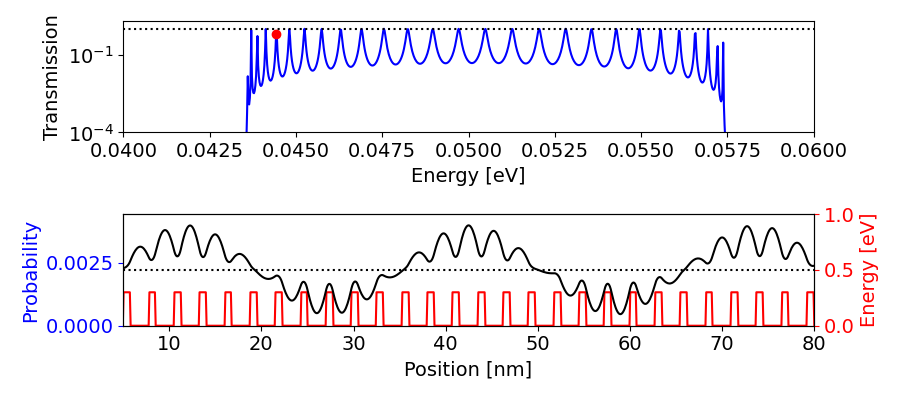

FloatRangeSlider(value=(0.01, 0.6), continuous_update=False, description='\\(E_{min}:E_{max}\\)', layout=Layou…

FloatSlider(value=0.25, continuous_update=False, description='\\(\\psi(z;E)\\)', layout=Layout(height='50px', …

In [4]:
#Arrange input controls widgets
vbox1 = widgets.VBox([sliderWellWidth ,sliderWellWidthDelta])
vbox2 = widgets.VBox([sliderBarrierWidth, sliderV0])

display(widgets.HBox([numWells, vbox1, vbox2]))

#Set up figures
fig1 = plt.figure(figsize=[9,4], tight_layout=True)
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_subplot(2,1,2)
ax2_twin = ax2.twinx()
ax1.set_xlabel('Energy [eV]')
ax1.set_ylabel('Transmission')
ax2.set_xlabel('Position [nm]')
ax2.set_ylabel('Probability')
ax2_twin.set_ylabel('Energy [eV]')
p1, = ax1.semilogy([], [], 'b')
p1a, = ax1.semilogy([], [], c='r', marker="o")
p1b, = ax1.semilogy([], [], 'g')
p1c, = ax1.semilogy([], [], 'k',linestyle='dotted')
p2, = ax2.plot([], [], 'b')
p3, = ax2_twin.plot([], [], 'r')
p3a, = ax2_twin.plot([], [], 'k',linestyle='dotted')
p3b, = ax2_twin.plot([], [], 'k')
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')
ax2_twin.tick_params(axis='y', colors='red')
ax2_twin.yaxis.label.set_color('red')

#This function finds peaks and populates drop down menu
def update_peaks(E,t):
    # Find new peaks from transmission
    peaks, _ = scipy.signal.find_peaks(abs(t)**2,
                        height=None,
                        threshold=None,
                        distance=None,
                        prominence=None,
                        width=None,
                        wlen=None,
                        rel_height=0.5,
                        plateau_size=None)
    
    #Set new values to the drop down meu
    selectPeak.options= E[peaks]
    
#This function updates the transmission spectrum plot given an energy range and a structure
def update_spectrum(EnergyRange):
    #Get current Structure
    V, d = generate_struc(numWells.value,sliderV0.value,sliderWellWidth.value,sliderWellWidthDelta.value,sliderBarrierWidth.value)
    
    #Run main code to get new spectrum and plot it
    E, t, r, detT = transferMatrix(EnergyRange, d, V)
    
    p1.set_data(E, np.abs(t)**2)
    p1b.set_data([np.max(V),np.max(V)], [1e-5, 2])
    p1c.set_data([EnergyRange[0], EnergyRange[1]], [1, 1])
    
    #Set axis limits for new data.
    ax1.set_xlim([np.min(E), np.max(E)])
    ax1.set_ylim([1e-4, 2])
    ax2_twin.set_xlim([0, np.sum(d)*1e9])
    ax2_twin.set_ylim([0, 1])
    
    #Set new values for range slider
    energy.max = np.max(E)
    energy.min = np.min(E)
    energy.step = E[1]-E[0]
    
    #Find new peaks and update drop down menu
    update_peaks(E,t)
    R = np.abs(r)**2
    T = np.abs(t)**2
    return E, T, R
    
#This function updates the wavefunction plot given an energy   
def update_wavefunc(selectEnergy):
    #Get current Structure
    V, d = generate_struc(numWells.value,sliderV0.value,sliderWellWidth.value,sliderWellWidthDelta.value,sliderBarrierWidth.value)
    
    #Evaluate new wavefunctions and plot them
    z, amp, prob, VV, t = transferMatrix_z(selectEnergy, d, V)
    p1a.set_data(selectEnergy, np.abs(t)**2)
    probability = prob/np.sum(prob)
    p2.set_data([], [])
    if plotProb.value == True:
        p2.set_data(z*1e9, probability)
        
    p3.set_data(z*1e9, VV)
    p3a.set_data([5, np.max(z)*1e9-5], [0.5, 0.5])
    
    #Prepare to plot amplitude response
    amplitude = 0.4*amp/np.max(np.abs(amp))+0.5
    p3b.set_data([], [])
    if plotAmp.value == True:
        p3b.set_data(z*1e9, amplitude)
    
    #Set new axis limits for probability.
    ax2.set_xlim([5, np.max(z)*1e9-5])
    ax2.set_ylim([np.min(prob)*1.1, np.max(probability)*1.1])
    ax2_twin.set_xlim([5, np.max(z)*1e9-5])
    ax2_twin.set_ylim([0, 1])
    return z, amp, prob, VV

# Slider for choosing spectral range
EnergyMaxMin = widgets.FloatRangeSlider(
    value=[MaxMinStart[0], MaxMinStart[1]],
    min=MaxMinStart[0],
    max=MaxMinStart[1],
    step=0.005,
    description=r'\(E_{min}:E_{max}\)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout=Layout(width='900px', height='50px'),
    align_items='stretch',
    )
widgets.interactive(update_spectrum, EnergyRange=EnergyMaxMin)

# Slider for chooing the wavefunction energy.
energy = widgets.FloatSlider(
    value=0.25,
    min=MaxMinStart[0],
    max=MaxMinStart[1],
    step=0.01,
    description=r'\(\psi(z;E)\)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=Layout(width='900px', height='50px'),
    align_items='stretch',
    )
widgets.interactive(update_wavefunc, selectEnergy=energy)

#Drop down menu for peaks
selectPeak = widgets.Dropdown(
    options=[],
    description='Peak Energy:',
    disabled=False,
    layout=Layout(width='300px', height='50px'),
    )
widgets.interactive(update_wavefunc, selectEnergy=selectPeak)

#Turn on or off the probability plot
plotProb = widgets.ToggleButton(
    value=True,
    description='Show Probablity',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='', # (FontAwesome names without the `fa-` prefix),
    layout=Layout(width='200px', height='50px'),
)

#Turn on or off the amplitude plot
plotAmp = widgets.ToggleButton(
    value=False,
    description='Show Ampltiude',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='', # (FontAwesome names without the `fa-` prefix),
    layout=Layout(width='200px', height='50px'),
)

hbox2 = widgets.HBox([selectPeak, plotAmp, plotProb])

#Display plot limit and selection controls first controls
display(EnergyMaxMin, hbox2, energy)

# Run calculation
update_spectrum(EnergyMaxMin.value)

#Callback for a change in the number of wells or well parameters
def on_change_range(value):
    update_spectrum(EnergyMaxMin.value)
    update_wavefunc(selectPeak.value)
numWells.observe(on_change_range,'value')
sliderV0.observe(on_change_range,'value')
sliderWellWidth.observe(on_change_range,'value')
sliderWellWidthDelta.observe(on_change_range,'value')
sliderBarrierWidth.observe(on_change_range,'value')
plotAmp.observe(on_change_range,'value')
plotProb.observe(on_change_range,'value')

<a id='visualisation'></a>

<a id='makeCalculations'></a>

In [5]:
print(selectPeak.options)

(0.04953350296861747, 0.19115351993214588, 0.4083375742154368)


## Making your own calculations
You can now access the function to undertake your own calculations. You just need to learn about the various bits of code.

### Generate a structure
The following snippet of code creates an array of quanutm wells.

In [6]:
#Number of quantum wells
N = 1

#Barrier height
V0 = 0.5 # Units are eV

#Quantum well width
dW = 2 # Units are nm

#Difference in width of even well numbers from left (z=0)
delta = 0

#Barrier width. Be aware, larger barriers can lead to floating point errors. Choose a value less than 1 nm! 
dB = 0.75 # Units are nm

# Call this function to generate the arrays for potential and layer thickness.
V1,d1 = generate_struc(N,V0,dW,delta,dB)

# set input output regions to 0
d1[0]=0
d1[4]=0
print("V=",V1," eV")
print("d=",d1," nm")

V= [0.  0.5 0.  0.5 0. ]  eV
d= [0.0e+00 7.5e-10 2.0e-09 7.5e-10 0.0e+00]  nm


### Calculate the transmission spectrum
Using the following code snippet, you can calculate a transmission spectrum for the given V and d arrays above.

<IPython.core.display.Javascript object>


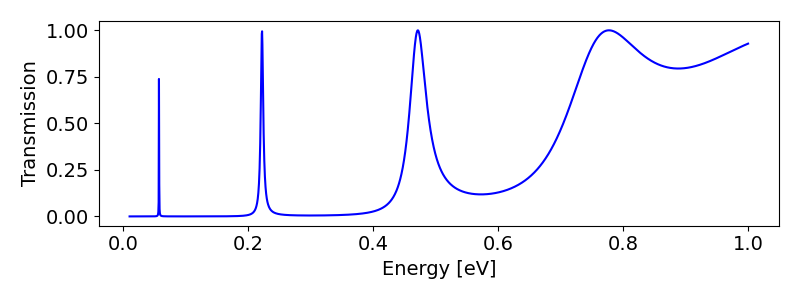

In [7]:
# Enter minimum and maximum energy value then execute code
E1, t1, r1, detT = transferMatrix([0.01, 2*V0],d1,V1)

# E1 is the energy array
# t1 and r1 are the transmissionand reflection coefficients. 
# detT is the Tranfer matrix determinent. It is useful to monitor for floaring point errors for large structures

fig2 = plt.figure(figsize=[8,3], tight_layout=True)
ax3 = fig2.add_subplot(1,1,1)
ax3.set_xlabel('Energy [eV]')
ax3.set_ylabel('Transmission')
ax3.plot(E1, np.abs(t1)**2, 'b')

### Idenitfy the quantum well states 
Using the following code snippet, you can find the peaks of the transmission spectrum and use this to identify the states of the quantum well array.

In [8]:
# One way to do this to find the peaks of the transmission spectrum
# Find new peaks from transmission
peaks, _ = scipy.signal.find_peaks(np.abs(t1)**2,rel_height=0.5)

print("First 3 QW array State energies = ",E1[peaks[0:3]],"eV")

First 3 QW array State energies =  [0.05702375 0.22210712 0.47123295] eV


### Calculate a wavefunction
Using the following snippet, you can calculate the wavefunction for a given energy. In this snippet the amplitude of the wavefunction is plotted. Note that this includes electron amplitude outside of the quantum well, due to the incident electron. This is supressed for energy states deeper in quantum wells and for thicker barriers. 

<IPython.core.display.Javascript object>


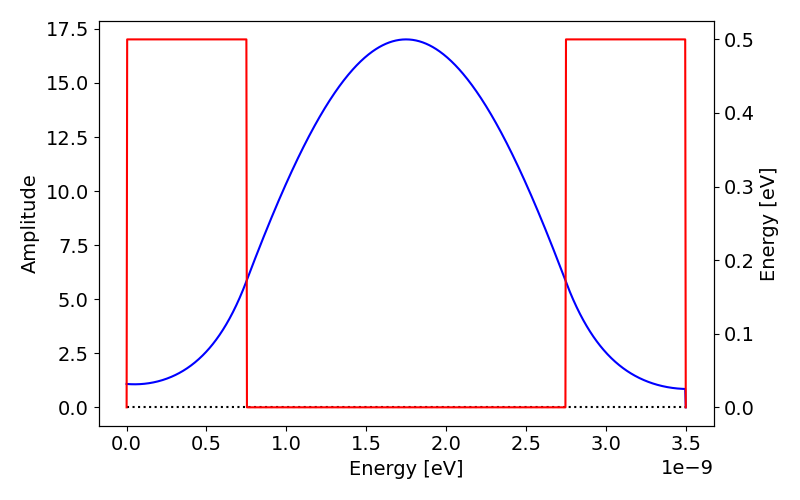

In [9]:
# We just need to specify an energy at which to evaluate the wavefunction.
# Let's plot the wavefunction of the first peak in the quannutm well spectrum
E0 = E1[peaks[0]]

# This function calculates the wavefunction and returns amplitude and probability
z1, amp1, prob1, VV1, t0 = transferMatrix_z(E0,d1,V1)

# z1 is the position array
# amp1 and prob1 are ampltiude and probablity density of the wavefunction respectively (not normalised!)
# VV1 is the potential as a function of position.

# Set up figure
fig3 = plt.figure(figsize=[8,5], tight_layout=True)
ax4 = fig3.add_subplot(1,1,1)
ax4.set_xlabel('Energy [eV]')
ax4.set_ylabel('Amplitude')
ax4_twin = ax4.twinx()
ax4_twin.set_ylabel('Energy [eV]')

# Plot data
ax4.plot(z1, np.real(amp1), 'b')
ax4.plot([np.min(z1), np.max(z1)], [0, 0], 'k',linestyle='dotted')
ax4_twin.plot(z1, VV1, 'r')


In [10]:
#Construct Bloch wavefunction:

           